Class distribution before augmentation: {0: 284315, 1: 492}


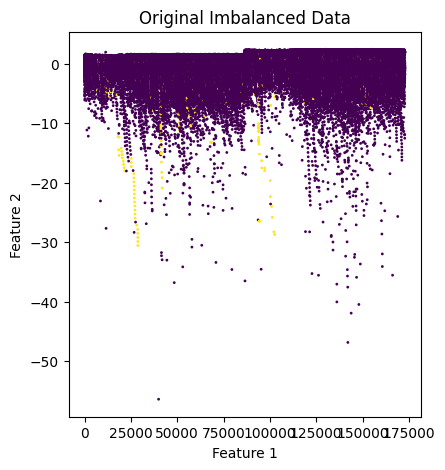

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score

# Step 1: Load the CSV file
data = pd.read_csv('creditcard.csv')

# Step 2: Inspect the data and check for class imbalance
# Assuming the last column is the label, and the rest are features
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Plot the original imbalanced data (first two features for visualization)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', label='Original Data', s=1)
plt.title('Original Imbalanced Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Separate the minority class
X_minority = X[y == 1]
# Identify integer columns
int_columns = data.select_dtypes(include=['int']).columns
int_indexes = []
for col in int_columns:
    col_index = data.columns.get_loc(col)
    int_indexes.append(col_index)
# Step 4: Upsample the minority class using ForestDiffusionModel
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=int_indexes, diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X)//50 )  # Adjust the batch size to create a balanced dataset

# Add generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)



# Step 5: Plot the generated data (first two features for visualization)
plt.subplot(1, 2, 2)
plt.scatter(X_balanced[:, 0], X_balanced[:, 1], c=y_balanced, cmap='viridis', label='Generated Data', s=1)
plt.title('Data After Generation')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 6: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 7: Train a simple classifier on both original and generated datasets
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

# Step 8: Predict and calculate recall and F1 scores
y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recalls_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)

# Step 9: Print the performance metrics
print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recalls_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")
print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))

# Step 10: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake)}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier

# Step 1: Load the CSV file
file_path = 'creditcard.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Calculate the correlation matrix for the original data
correlation_matrix = pd.DataFrame(X).corr()
print("Correlation Matrix of Original Data:")
print(correlation_matrix)

# Step 4: Separate the minority class
X_minority = X[y == 1]  # Assuming class '1' is the minority

# Step 5: Upsample the minority class using ForestDiffusionModel
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, 
                                     bin_indexes=[], cat_indexes=[], int_indexes=[], 
                                     diffusion_type='flow', n_jobs=-1)

# Generate synthetic data
X_minority_fake = forest_model.generate(batch_size=len(X) // 50)  # Adjust batch size

# Function to adjust the correlations of the generated data
def adjust_correlation(X, target_corr_matrix):
    L = np.linalg.cholesky(target_corr_matrix)
    X_centered = X - np.mean(X, axis=0)
    X_transformed = np.dot(X_centered, L.T)
    return X_transformed + np.mean(X, axis=0)

# Step 6: Adjust the synthetic data to match the original data's correlation matrix
X_minority_fake_adjusted = adjust_correlation(X_minority_fake, correlation_matrix)

# Step 7: Combine the original and adjusted synthetic data
X_balanced = np.concatenate((X, X_minority_fake_adjusted), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake_adjusted.shape[0])), axis=0)

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 8: Split the dataset into training and test sets
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 9: Train a Random Forest classifier on both original and generated datasets
clf_orig = RandomForestClassifier()
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = RandomForestClassifier()
clf_bal.fit(X_train_bal, y_train_bal)

# Step 10: Predict and calculate recall and F1 scores
y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_bal, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_bal, y_pred_bal)

# Step 11: Print the performance metrics
print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recall_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")

# Step 12: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake)}")
